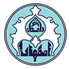







به نام خداوند بخشنده و مهربان 

# **درس: تحلیل سیسیتم داده‌های حجیم**
---

## استاد: دکتر محمدعلی نعمت‌بخش
دستیاران: فاطمه ابراهیمی، امیر سرتیپی، پریسا لطیفی





# تکلیف چهارم

# Load spark platform on google colab.

In [1]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet 
!apt install openjdk-8-jdk-headless &> /dev/null


     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 62.3 MB/s 


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Row
spark = SparkSession \
    .builder \
    .appName("BigData-HW4") \
    .getOrCreate()

In [9]:
CustomerInfo = spark.read.option("header",True) \
              .csv('/content/sample_data/data.csv')
CustomerInfo.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|5331-RGMTT|  Male|          1.0|    Yes|        No|  54.0|  

In [10]:
CustomerInfo.count()

229990

#  ستون های موجود در دیتاست اصلی

In [11]:
CustomerInfo.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Label']

##در هر ستون  missing-value تعداد 

In [20]:

CustomerInfo.select([count(when(isnan(c) | col(c).isNull() , c)).alias(c) for c in CustomerInfo.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|       253|   232|          264|    224|       242|   224|         268|          260|            229|           230|         241|             251|        262|        247|            218|     230|             256| 

برای انجام تغییرات روی دیتاست آن را به دیتاست دیگری انتقال میدهیم.

تمام ستون ها از نوع رشته هستند

In [13]:
MyCustomerInfo = CustomerInfo                                                      #.drop('customerID')
MyCustomerInfo.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Label: string (nullable = true)



# **پر کردن مقادیر خالی با مقادیر مناسب بر حسب نوع ستون**

In [14]:
from pyspark.sql.types import IntegerType

mean_Tenure = MyCustomerInfo.agg({'tenure': 'mean'})
mean_Tenure = str((float(int(mean_Tenure.collect()[0][0]))))

mean_MonthlyCharges = MyCustomerInfo.agg({'MonthlyCharges': 'mean'})
mean_MonthlyCharges = mean_MonthlyCharges.withColumn("avg(MonthlyCharges)"\
                                                     ,round(mean_MonthlyCharges["avg(MonthlyCharges)"], 2))
mean_MonthlyCharges = str(float(mean_MonthlyCharges.collect()[0][0]))


mean_TotalCharges = MyCustomerInfo.agg({'TotalCharges': 'mean'})
mean_TotalCharges = mean_TotalCharges.withColumn("avg(TotalCharges)"\
                                                 ,round(mean_TotalCharges["avg(TotalCharges)"], 2))
mean_TotalCharges = str(float(mean_TotalCharges.collect()[0][0]))

MyCustomerInfo = MyCustomerInfo.fillna({'tenure':mean_Tenure \
                                        ,'MonthlyCharges':mean_MonthlyCharges \
                                        ,'TotalCharges':mean_TotalCharges})

for c in MyCustomerInfo.columns:
    if( c not in ['customerID','tenure' ,'MonthlyCharges' ,'TotalCharges'] ):
      mode_c = MyCustomerInfo.groupBy(c).count()
      mode_c = mode_c.orderBy(col('count').desc())
      mode_c = mode_c.collect()[0][0]
      MyCustomerInfo = MyCustomerInfo.fillna({c : mode_c})

     

  

In [51]:

MyCustomerInfo.select([count(when(isnan(c) | col(c).isNull() , c)).alias(c) for c in MyCustomerInfo.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|       253|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [27]:
MyCustomerInfo = MyCustomerInfo.withColumn("tenure",MyCustomerInfo['tenure'].cast('float'))
MyCustomerInfo = MyCustomerInfo.withColumn("MonthlyCharges",MyCustomerInfo['MonthlyCharges'].cast('float'))
MyCustomerInfo = MyCustomerInfo.withColumn("TotalCharges",MyCustomerInfo['TotalCharges'].cast('float'))
MyCustomerInfo.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = false)
 |-- SeniorCitizen: string (nullable = false)
 |-- Partner: string (nullable = false)
 |-- Dependents: string (nullable = false)
 |-- tenure: float (nullable = true)
 |-- PhoneService: string (nullable = false)
 |-- MultipleLines: string (nullable = false)
 |-- InternetService: string (nullable = false)
 |-- OnlineSecurity: string (nullable = false)
 |-- OnlineBackup: string (nullable = false)
 |-- DeviceProtection: string (nullable = false)
 |-- TechSupport: string (nullable = false)
 |-- StreamingTV: string (nullable = false)
 |-- StreamingMovies: string (nullable = false)
 |-- Contract: string (nullable = false)
 |-- PaperlessBilling: string (nullable = false)
 |-- PaymentMethod: string (nullable = false)
 |-- MonthlyCharges: float (nullable = true)
 |-- TotalCharges: float (nullable = true)
 |-- Label: string (nullable = false)



In [128]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

num_col = ['tenure','MonthlyCharges','TotalCharges']
cat_col = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',\
                      'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies',\
                        'Contract','PaperlessBilling','PaymentMethod']
indexers = [StringIndexer(inputCol=column, outputCol= "{0}_indexed".format(column)).fit(MyCustomerInfo) for column in cat_col ]
Label_indexer = StringIndexer(inputCol='Label',outputCol= "Label_indexed")
encoders = [OneHotEncoder(dropLast=False,inputCol = indexer.getOutputCol()\
                          , outputCol= "{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]

assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]+ num_col,outputCol="features")

pipeline = Pipeline(stages=indexers + encoders+[assembler]+ [Label_indexer])
model = pipeline.fit(MyCustomerInfo)
MyCustomerInfo_tr = model.transform(MyCustomerInfo)
MyCustomerInfo_tr.show()



+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+----------------------+-----------------------------+-----------------------+--------------------------+----------------------------+-----------------------------+-------------------------------+------------------------------+----------------------------+--------------------------------+---------------------------+---------------------------+--------

##**بعد از پرکردن مقادیر خالی به تحلیل اثر هر ستون در پیش بینی می پردازیم**





# **(customerID)ستون اول**
# این ستون اثری در پیش بینی مدل نخواهد داشت فقط به عنوان شناسه استفاده خواهد شد
# پس در آموزش مدل از آن استفاده نمیکنیم

 
# **(gender) ستون دوم**

# همانطور که از نتیجه ی زیر مشخص است

# **زن** یا **مرد** بودن تاثیر چندانی در پیش بینی ندارد

# پس بهتر است این ستون را حذف کنیم

In [129]:
gender_dependency = MyCustomerInfo_tr.groupBy('gender','Label').count()
gender_dependency.show()
print('corrolation between gender and Label:')
MyCustomerInfo_tr.corr('gender_indexed','Label_indexed','pearson')


+------+-----+-----+
|gender|Label|count|
+------+-----+-----+
|  Male|   No|98693|
|  Male|  Yes|17845|
|Female|   No|97393|
|Female|  Yes|16059|
+------+-----+-----+

corrolation between gender and Label:


-0.016326515705542194

In [130]:
MyCustomerInfo_tr.drop('gender','gender_indexed','gender_indexed_end=coded').show()

+----------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+----------------------+-----------------------------+-----------------------+--------------------------+----------------------------+-----------------------------+-------------------------------+------------------------------+----------------------------+--------------------------------+---------------------------+---------------------------+------------------------------

# **(SeniorCitizen) ستون سوم**
# در این ستون تعدادی داده پرت مشاهده می شود . این داده ها باید اصلاح شوند
با توجه به اینکه بزرگتر از 1 هستند  آنها را یک قرار می دهیم

# با توجه مقدار همبستگی  و نتایج زیر نیاز به حذف این ستون نیست

In [91]:
MyCustomerInfo_tr.groupBy('SeniorCitizen','Label').count().show()

+-------------+-----+------+
|SeniorCitizen|Label| count|
+-------------+-----+------+
|         14.0|   No|   548|
|          1.0|  Yes| 10046|
|         17.0|   No|     6|
|         14.0|  Yes|   246|
|          1.0|   No| 28139|
|          0.0|  Yes| 23612|
|          0.0|   No|167393|
+-------------+-----+------+



In [131]:
MyCustomerInfo_tr = MyCustomerInfo_tr.withColumn("SeniorCitizen", when(col("SeniorCitizen")>=1, 1).otherwise(0))
MyCustomerInfo_tr.groupBy('SeniorCitizen','Label').count().show()
print('corrolation between SeniorCitizen and Label:')
MyCustomerInfo_tr.corr('SeniorCitizen_indexed','Label_indexed','pearson')

+-------------+-----+------+
|SeniorCitizen|Label| count|
+-------------+-----+------+
|            1|   No| 28693|
|            0|   No|167393|
|            0|  Yes| 23612|
|            1|  Yes| 10292|
+-------------+-----+------+

corrolation between SeniorCitizen and Label:


0.14788531816558

(array([191005.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  38985.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

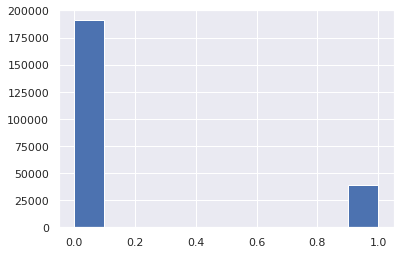

In [71]:
import matplotlib.pyplot as plt

citizen = MyCustomerInfo_tr.select("SeniorCitizen").rdd.flatMap(lambda  x: x).collect()
plt.hist(citizen)

# **(Partner) ستون چهارم**


In [113]:
MyCustomerInfo_tr.groupBy('Partner').count().show()
MyCustomerInfo_tr.groupBy('Partner','Label').count().show()
print('corrolation between Partner and Label:')
MyCustomerInfo_tr.corr('Partner_indexed','Label_indexed','pearson')

+-------+------+
|Partner| count|
+-------+------+
|     No| 85648|
|    Yes|144342|
+-------+------+

+-------+-----+------+
|Partner|Label| count|
+-------+-----+------+
|    Yes|  Yes| 18044|
|     No|   No| 69788|
|    Yes|   No|126298|
|     No|  Yes| 15860|
+-------+-----+------+

corrolation between Partner and Label:


0.08204854679463729

(array([178246.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 281734.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

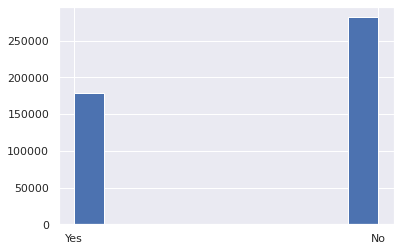

In [112]:
import matplotlib.pyplot as plt

partner = MyCustomerInfo_tr.select("Partner","label").rdd.flatMap(lambda  x: x).collect()
plt.hist(partner)

# **(ِDependent) ستون پنجم**

از جدول زیر اینطور استنباط می شود که این فاکتور در مقدار لیبل موثر است تعداد زیادی از برچسب ها متناسب با مقدار این فاکتور هستند

In [115]:
MyCustomerInfo_tr.groupBy('Dependents').count().show()
MyCustomerInfo_tr.groupBy('Dependents','Label').count().show()
print('corrolation between Dependent and Label:')
MyCustomerInfo_tr.corr('Dependents_indexed','Label_indexed','pearson')

+----------+------+
|Dependents| count|
+----------+------+
|        No|148232|
|       Yes| 81758|
+----------+------+

+----------+-----+------+
|Dependents|Label| count|
+----------+-----+------+
|       Yes|  Yes|  7264|
|        No|   No|121592|
|       Yes|   No| 74494|
|        No|  Yes| 26640|
+----------+-----+------+

corrolation between Dependent and Label:


-0.12269058784498946

# **(ِtenure) ستون ششم**

به نظر می رسد که داده های منفی پرت هستند.
آن ها را با میانگین جایگزین میکنیم

In [132]:
MyCustomerInfo_tr.groupBy('tenure','Label').count().show()


+------+-----+-----+
|tenure|Label|count|
+------+-----+-----+
|  24.0|  Yes|  552|
|-592.0|   No|   16|
|  69.0|   No| 6003|
|-585.0|   No|   30|
|  51.0|  Yes|  408|
|-593.0|  Yes|   14|
|  47.0|   No| 2538|
|-584.0|   No|   32|
|  15.0|   No|  915|
|  21.0|  Yes|  357|
|  41.0|  Yes|  574|
|  58.0|   No| 3306|
|  63.0|   No| 4284|
|  63.0|  Yes|  252|
|  59.0|   No| 3068|
|  14.0|  Yes|  336|
|  39.0|   No| 1638|
|  36.0|  Yes|  360|
|  66.0|   No| 5019|
|  18.0|  Yes|  432|
+------+-----+-----+
only showing top 20 rows

corrolation between tenure and Label:


-0.12676387947366066

In [133]:
MyCustomerInfo_tr = MyCustomerInfo_tr.withColumn("tenure", when(col("tenure")<=0, mean_Tenure).otherwise(col("tenure")))

In [137]:
MyCustomerInfo_tr =MyCustomerInfo_tr.withColumn("tenure",MyCustomerInfo_tr['tenure'].cast('float'))

In [139]:
MyCustomerInfo_tr.groupBy('tenure','Label').count().show()
print('corrolation between tenure and Label:')
MyCustomerInfo_tr.corr('tenure','Label_indexed','pearson')

+------+-----+-----+
|tenure|Label|count|
+------+-----+-----+
|  24.0|  Yes|  552|
|  69.0|   No| 6003|
|  51.0|  Yes|  408|
|  47.0|   No| 2538|
|  15.0|   No|  915|
|  21.0|  Yes|  357|
|  41.0|  Yes|  574|
|  58.0|   No| 3306|
|  63.0|   No| 4284|
|  63.0|  Yes|  252|
|  59.0|   No| 3068|
|  14.0|  Yes|  336|
|  39.0|   No| 1638|
|  36.0|  Yes|  360|
|  66.0|   No| 5019|
|  18.0|  Yes|  432|
|  34.0|   No| 1802|
|  68.0|  Yes|  680|
|  22.0|  Yes|  594|
|  14.0|   No|  714|
+------+-----+-----+
only showing top 20 rows

corrolation between tenure and Label:


-0.2561566998567579

# **(ِPhoneService) ستون هفتم**

In [140]:
MyCustomerInfo_tr.groupBy('PhoneService','Label').count().show()
print('corrolation between PhoneService and Label:')
MyCustomerInfo_tr.corr('PhoneService_indexed','Label_indexed','pearson')

+------------+-----+------+
|PhoneService|Label| count|
+------------+-----+------+
|         Yes|  Yes| 31196|
|          No|   No| 19109|
|         Yes|   No|176977|
|          No|  Yes|  2708|
+------------+-----+------+

corrolation between MultipleLines and Label:


-0.021268995159031242

# **(ِMultipleLines) ستون هشتم**

In [141]:
MyCustomerInfo_tr.groupBy('MultipleLines','Label').count().show()
print('corrolation between MultipleLines and Label:')
MyCustomerInfo_tr.corr('MultipleLines_indexed','Label_indexed','pearson')

+----------------+-----+------+
|   MultipleLines|Label| count|
+----------------+-----+------+
|No phone service|   No| 19110|
|             Yes|  Yes| 22182|
|              No|   No| 73492|
|             Yes|   No|103484|
|No phone service|  Yes|  2707|
|              No|  Yes|  9015|
+----------------+-----+------+

corrolation between MultipleLines and Label:


-0.07725986644163231

# **(ِInternetService) ستون نهم**

In [142]:
MyCustomerInfo_tr.groupBy('InternetService','Label').count().show()
print('corrolation between InternetService and Label:')
MyCustomerInfo_tr.corr('InternetService_indexed','Label_indexed','pearson')

+---------------+-----+-----+
|InternetService|Label|count|
+---------------+-----+-----+
|            DSL|  Yes| 6513|
|    Fiber optic|  Yes|26459|
|             No|   No|45985|
|    Fiber optic|   No|76491|
|             No|  Yes|  932|
|            DSL|   No|73610|
+---------------+-----+-----+

corrolation between InternetService and Label:


-0.27517341751687435

# **Logistic Regression الگوریتم**

دیتافریم جدیدی از دیتافریم قبلی ایجاد کرده و ستونهای مورد نیاز برای آموزش  و تست را در بردارد.

In [143]:
MyCustomerInfo2 = MyCustomerInfo_tr.select('customerID','features','Label_indexed')
MyCustomerInfo2 = MyCustomerInfo2.withColumnRenamed('Label_indexed','label')
MyCustomerInfo2.na.drop()
MyCustomerInfo2.show(50)

+----------+--------------------+-----+
|customerID|            features|label|
+----------+--------------------+-----+
|5331-RGMTT|(48,[0,3,6,8,10,1...|  0.0|
|5161-XEUVX|(48,[0,2,6,8,10,1...|  0.0|
|0336-PIKEI|(48,[0,3,6,8,10,1...|  0.0|
|3345-PBBFH|(48,[0,2,6,8,10,1...|  0.0|
|5067-XJQFU|(48,[0,3,6,9,10,1...|  0.0|
|4056-QHXHZ|(48,[1,2,6,9,10,1...|  0.0|
|8028-PNXHQ|(48,[0,2,6,9,10,1...|  0.0|
|8181-YHCMF|(48,[1,2,6,9,11,1...|  0.0|
|6734-PSBAW|(48,[0,2,6,8,10,1...|  0.0|
|3655-SNQYZ|(48,[1,2,6,9,10,1...|  0.0|
|9508-ILZDG|(48,[1,3,7,8,10,1...|  0.0|
|3620-EHIMZ|(48,[1,2,6,9,10,1...|  0.0|
|4178-EGMON|(48,[0,2,6,8,10,1...|  0.0|
|0036-IHMOT|(48,[1,2,6,9,10,1...|  0.0|
|0281-CNTZX|(48,[0,2,6,8,10,1...|  0.0|
|0530-IJVDB|(48,[0,2,7,9,10,1...|  0.0|
|7251-XFOIL|(48,[1,2,7,8,10,1...|  0.0|
|7079-QRCBC|(48,[1,2,7,8,10,1...|  1.0|
|2908-ZTPNF|(48,[1,2,7,8,11,1...|  0.0|
|0640-YJTPY|(48,[0,2,6,9,10,1...|  0.0|
|6147-CBCRA|(48,[1,2,6,8,10,1...|  0.0|
|3259-KNMRR|(48,[0,3,7,8,10,1...|  0.0|


In [144]:
from pyspark.ml.classification import LogisticRegression

train_data , test_data = MyCustomerInfo2.randomSplit([0.7,.3],seed=200)
log_reg = LogisticRegression(featuresCol='features',labelCol='label')
fit_model = log_reg.fit(train_data)
results = fit_model.transform(test_data)

In [103]:
results.show()

+----------+--------------------+-----+--------------------+--------------------+----------+
|customerID|            features|label|       rawPrediction|         probability|prediction|
+----------+--------------------+-----+--------------------+--------------------+----------+
|      null|(47,[0,2,6,8,10,1...|  0.0|[4.20240678706489...|[0.98526096003936...|       0.0|
|      null|(47,[0,2,6,8,10,1...|  0.0|[5.64276210134641...|[0.99646944045063...|       0.0|
|      null|(47,[0,2,6,8,10,1...|  0.0|[5.75521478992064...|[0.99684376688432...|       0.0|
|      null|(47,[0,2,6,8,10,1...|  0.0|[5.82122475886831...|[0.99704478640371...|       0.0|
|      null|(47,[0,2,6,8,10,1...|  0.0|[5.86071506324827...|[0.99715888931656...|       0.0|
|      null|(47,[0,2,6,8,10,1...|  0.0|[5.19932859829949...|[0.99451003658243...|       0.0|
|      null|(47,[0,2,6,8,10,1...|  0.0|[5.08818825166994...|[0.99386863873073...|       0.0|
|      null|(47,[0,2,6,8,10,1...|  0.0|[5.32276703902934...|[0.9951444

In [145]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='label')
results.select('label','prediction')
accuracy = my_eval.evaluate(results)
print("accuracy is : ",accuracy)

accuracy is :  0.618722297478557


 MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
# cchart for distribution of target variable

sns.countplot (x ="Label", data = MyCustomerInfo)

AttributeError: ignored